In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

REF_PATH = "/home/yifan/experiments/noise/20/experiment1"
CONFIG_PATH = "/home/yifan/experiments/noise/20"
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

# CLEAN_PATH = "/home/yifan/Exp/Noise/0.2/experiment1"
# CONFIG_PATH = "/home/yifan/experiments/noise/20"
# REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'baseline'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(CONFIG_PATH,REF_PATH,REF_EPOCH,DEVICE)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH,DEVICE)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,1.0,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 298.62it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 3748.41it/s]


absolute alignment indicates number: 8 label diff indicates number: 10042 confidence diff indicates number: 31 high distance number: 12493


In [2]:
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
autoencoder = SimpleAutoencoder(512,512)
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/ref_noise.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 2689.24it/s]


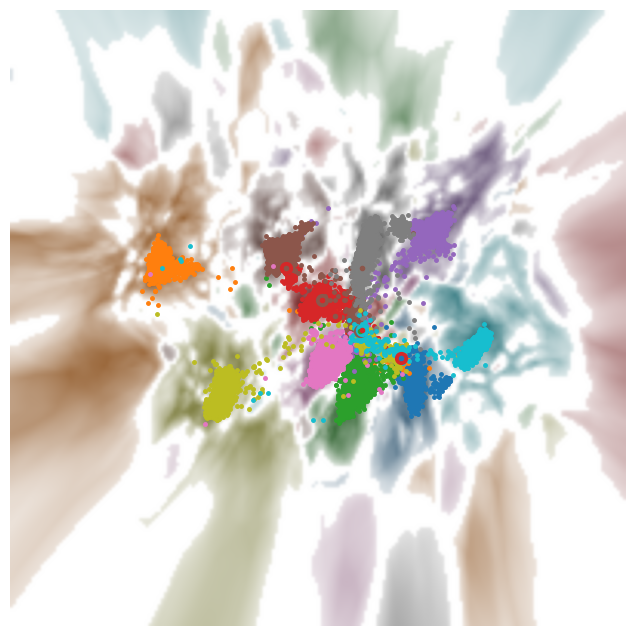

In [3]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(CLEAN_PATH, "vis.png"))

In [4]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)

In [5]:
eval.eval_nn_train_autoencoder(15,autoencoder )

Fri May 12 11:48:28 2023 Building RP forest with 16 trees
Fri May 12 11:48:29 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri May 12 11:48:51 2023 Building RP forest with 16 trees
Fri May 12 11:48:51 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.22/15 in epoch 200


1.22024

In [14]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 4376.74it/s]

refere  predction preserving:45652/50000 0.91
target  predction preserving:48385/50000 0.97
ref&tar pred_same preserving:37401/39958 0.94
ref&tar pred_diff preserving:9700/10042 0.97


In [15]:
eval.eval_move_direction_preserving(autoencoder,10,1.5)

100%|██████████| 250/250 [00:00<00:00, 6041.92it/s]


long distance move subet number is 28776, short distance move set number is 33


100%|██████████| 250/250 [00:00<00:00, 4004.23it/s]


all reference distance preserving 49143/50000
all target distance preserving 49545/50000
short distance move direction preserving 30/33
long distance move direction preserving 28032/28776


In [10]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,CONFIG_PATH,CLEAN_PATH,CLEAN_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=1000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 3806.17it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:03<00:00, 73.83it/s]


conf1 (3996, 10) (3980, 10) (3996, 10) (3980, 10)
conf1 (4002, 10) (3996, 10) (4002, 10) (3996, 10)
conf1 (4002, 10) (4016, 10) (4002, 10) (4016, 10)
conf1 (3996, 10) (3972, 10) (3996, 10) (3972, 10)
conf1 (4002, 10) (4026, 10) (4002, 10) (4026, 10)
conf1 (3996, 10) (3949, 10) (3996, 10) (3949, 10)
conf1 (4024, 10) (3949, 10) (4024, 10) (3949, 10)
conf1 (3997, 10) (3972, 10) (3997, 10) (3972, 10)
conf1 (4024, 10) (4016, 10) (4024, 10) (4016, 10)
conf1 (3997, 10) (4016, 10) (3997, 10) (4016, 10)
conf1 (3980, 10) (4026, 10) (3980, 10) (4026, 10)
conf1 (4002, 10) (3980, 10) (4002, 10) (3980, 10)
conf1 (3997, 10) (3972, 10) (3997, 10) (3972, 10)
conf1 (3972, 10) (4016, 10) (3972, 10) (4016, 10)
conf1 (3996, 10) (3997, 10) (3996, 10) (3997, 10)
conf1 (3996, 10) (4002, 10) (3996, 10) (4002, 10)
conf1 (3972, 10) (3996, 10) (3972, 10) (3996, 10)
conf1 (4024, 10) (4026, 10) (4024, 10) (4026, 10)
conf1 (3972, 10) (3980, 10) (3972, 10) (3980, 10)
conf1 (3996, 10) (4024, 10) (3996, 10) (4024, 10)


In [8]:
TAR_PATH = CLEAN_PATH

In [9]:
import os
ref_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
tar_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
if os.path.exists(ref_border_path) and os.path.exists(tar_border_path):
    print("aaa")
    ref_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
    ref_features = np.load(ref_border_centers_loc).squeeze()
    tar_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
    tar_features = np.load(tar_border_centers_loc).squeeze()

In [11]:
eval.eval_boundary_nn_ref_in_ref(ref_features)

#train# boundary preserving: 1.81/15 in epoch 200


1.81366

In [12]:
eval.eval_boundary_nn_autoencoder(tar_features,autoencoder)

#train# boundary preserving: 2.56/15 in epoch 200


2.56422

In [13]:
def eval_boundary_align_sensitivity(autoencoder, tar_b_features, ref_b_features):
        ############## init ###################
        #init target
        print("123")
        tar_b_pred = tar_provider.get_pred(TAR_EPOCH, tar_b_features)
        tar_b_pred = tar_b_pred + 1e-8
        tar_sort_preds = np.sort(tar_b_pred, axis=1)
        tar_diff = (tar_sort_preds[:, -1] - tar_sort_preds[:, -2]) / (tar_sort_preds[:, -1] - tar_sort_preds[:, 0])
        tar_border = np.zeros(len(tar_diff), dtype=np.uint8) + 0.05
        tar_border[tar_diff < 0.15] = 1

        #init reference
        ref_b_pred = ref_provider.get_pred(REF_EPOCH, ref_b_features)
        ref_b_pred = ref_b_pred + 1e-8
        ref_sort_preds = np.sort(ref_b_pred, axis=1)
        ref_diff = (ref_sort_preds[:, -1] - ref_sort_preds[:, -2]) / (ref_sort_preds[:, -1] - ref_sort_preds[:, 0])
        ref_border = np.zeros(len(ref_diff), dtype=np.uint8) + 0.05
        ref_border[ref_diff < 0.15] = 1
        
        ##### get all boundary list
        all_boundary_list = []
        
        for i in range(len(ref_border)):
            if ref_border[i] == 1 and tar_border[i] == 1:
                all_boundary_list.append(i)
        print(len(all_boundary_list))
        #### get ref low dimensional border
        ref_b_embedding = projector.batch_project(REF_EPOCH, ref_b_features)
        ref_b_inv = projector.batch_inverse(REF_EPOCH,ref_b_embedding)
        ref_b_pred_l = ref_provider.get_pred(REF_EPOCH, ref_b_inv)
        ref_b_pred_l = ref_b_pred_l  + 1e-8
        ref_sort_preds_l  = np.sort(ref_b_pred_l , axis=1)
        ref_diff_l  = (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, -2]) / (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, 0])
        ref_border_l = np.zeros(len(ref_diff_l), dtype=np.uint8) + 0.05
        ref_border_l[ref_diff_l < 0.15] = 1
        
        #### get target low dimensional border
        tar_b_embedding = projector.batch_project(REF_EPOCH, autoencoder.encoder(torch.Tensor(ref_b_features)).detach().numpy())
        tar_b_inv = projector.batch_inverse(REF_EPOCH,tar_b_embedding)
        tar_b_inv = autoencoder.decoder(torch.Tensor(tar_b_inv)).detach().numpy()
        tar_b_pred_l = tar_provider.get_pred(REF_EPOCH, tar_b_inv)
        tar_b_pred_l = tar_b_pred_l  + 1e-8
        tar_sort_preds_l  = np.sort(tar_b_pred_l , axis=1)
        tar_diff_l  = (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, -2]) / (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, 0])
        tar_border_l = np.zeros(len(tar_diff_l), dtype=np.uint8) + 0.05
        tar_border_l[tar_diff_l < 0.15] = 1

        all_boundary_list_l = []
       
        all_change = []
        all_change_l=[]
      
        for i in range(len(ref_border)):
            ##### low dimension all border
            if ref_border_l[i] == 1 and tar_border_l[i] == 1:
                all_boundary_list_l.append(i)
            if ref_border[i] != tar_border[i]:
                 all_change.append(i)
            if ref_border[i] != tar_border[i] and tar_border_l[i] == tar_border[i]:
                 all_change_l.append(i)
                 
                 
           


        print("boundary sample preserving{}/{}".format(len(all_boundary_list_l),len(all_boundary_list)))
        print("boundary change preserving{}/{}".format(len(all_change_l),len(all_change)))
       
eval_boundary_align_sensitivity(autoencoder,np.concatenate((tar_train_data,tar_features),axis=0), np.concatenate((ref_train_data,ref_features),axis=0))      

123


100%|██████████| 255/255 [00:00<00:00, 3112.26it/s]


1013


100%|██████████| 255/255 [00:00<00:00, 4195.37it/s]

boundary sample preserving468/1013
boundary change preserving442/783


In [3]:
######### initialize autoencoder and dataloader #########################
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data import DataLoaderInit
input_dim = 512
output_dim = 512

autoencoder = SimpleAutoencoder(input_dim,output_dim)

In [4]:



######### train sample + generated boundary sample's => input  #############
input_X = np.concatenate((ref_provider.train_representation(REF_EPOCH), ref_features),axis=0)
input_Y = np.concatenate((tar_provider.train_representation(TAR_EPOCH), tar_features),axis=0)
data_loader_b = DataLoaderInit(input_X, input_Y)
data_loader = DataLoaderInit(ref_provider.train_representation(REF_EPOCH), tar_provider.train_representation(TAR_EPOCH))
dataloader = data_loader.get_data_loader()
dataloader_b = data_loader_b.get_data_loader()


In [25]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)
c_y = encoded_Y.detach().numpy()

from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between  target vs target is:         ',np_cka.kernel_CKA(Y[indicates],Y[indicates]))
# print('CKA between target and linear_target:     ',np_cka.kernel_CKA(Y[indicates],np.dot(Y[indicates],R_n_2.detach().numpy())))
print('CKA between target and autoencoder_target:',np_cka.kernel_CKA(Y[indicates],c_y[indicates]))
print('CKA between  ref vs autoencoder_target is:',np_cka.kernel_CKA(X[indicates],c_y[indicates]))
print('CKA between  ref vs target is:            ',np_cka.kernel_CKA(X[indicates],c_y[indicates]))

CKA between  target vs target is:          1.0
CKA between target and autoencoder_target: 0.9997682082771844
CKA between  ref vs autoencoder_target is: 0.5306002337622463
CKA between  ref vs target is:             0.5306002337622463


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8651.47it/s]


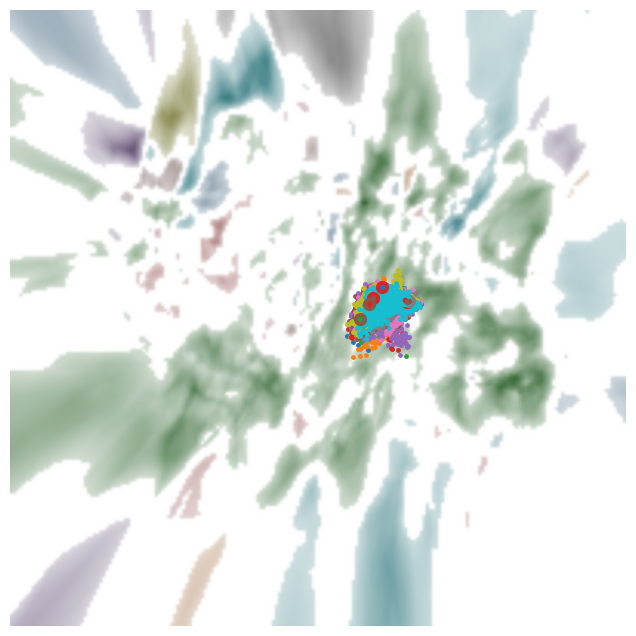

In [10]:
# checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/noise_flap.pth")
# autoencoder.load_state_dict(checkpoint['model_state_dict'])
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)

I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8259.11it/s]


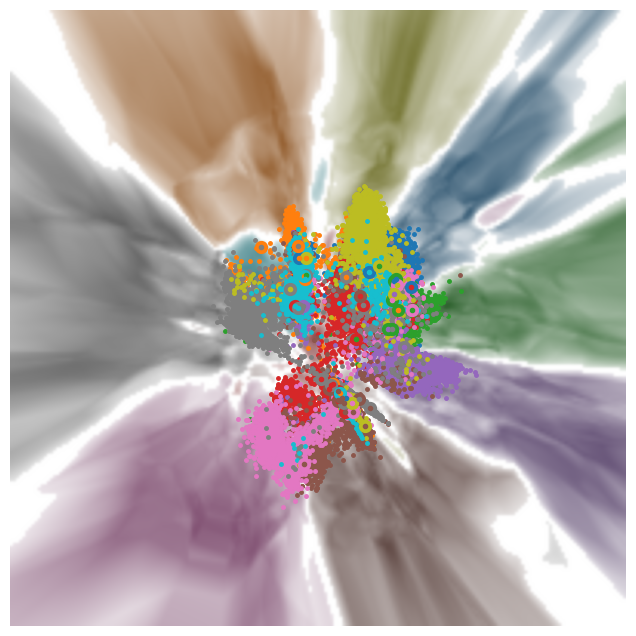

In [7]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)
VIS_MODEL_NAME = 'vis'
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
###### use auto encoder to visualize the prediction
Y = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
X = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 4524.64it/s]


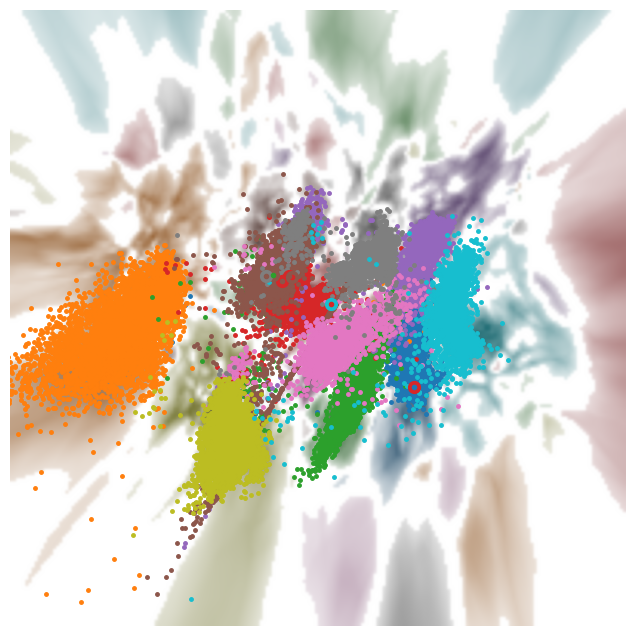

In [17]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)
VIS_MODEL_NAME = 'baseline'
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, tar_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9437.38it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

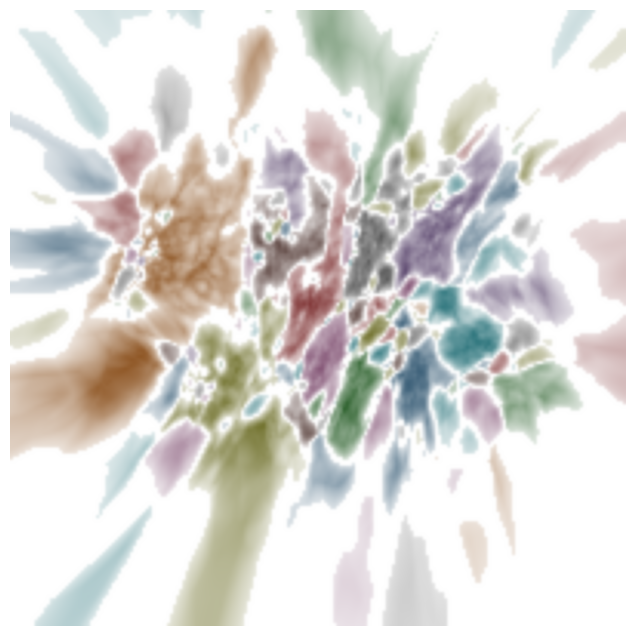

In [8]:


import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVisAutoEncoder.visualizer_inv import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_train_data, I), projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [9]:
from AlignVis_eval.Alignmenteval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)

In [10]:
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)

#train# boundary preserving: 1.18/15 in epoch 200


1.18216

In [15]:
eval.eval_nn_train_ref_in_ref(15)

Thu Apr 20 15:36:17 2023 Building RP forest with 16 trees
Thu Apr 20 15:36:17 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Thu Apr 20 15:36:19 2023 Building RP forest with 16 trees
Thu Apr 20 15:36:19 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving ref in ref: 1.26/15 in epoch 200


1.2603

In [13]:
eval.eval_nn_train_autoencoder(15,autoencoder )

Thu Apr 20 15:35:16 2023 Building RP forest with 16 trees
Thu Apr 20 15:35:17 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Apr 20 15:35:19 2023 Building RP forest with 16 trees
Thu Apr 20 15:35:19 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.22/15 in epoch 200


1.2204

In [12]:
from singleVis.eval.evaluate import *

train_data = encoded_Y.detach().numpy()
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)
new_inv = autoencoder.decoder(torch.Tensor(inv_data))
new_inv = new_inv.detach().numpy()
####### target prediction
pred = tar_provider.get_pred(TAR_EPOCH, tar_provider.train_representation(TAR_EPOCH)).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, new_inv).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# autoencoder PPR: {:.2f} in epoch {:d}".format(val, REF_EPOCH))


100%|██████████| 250/250 [00:00<00:00, 8578.50it/s]

#train# autoencoder PPR: 0.97 in epoch 200
